In [6]:
import pandas as pd
import numpy as np
import re
from tqdm import tqdm
from modules import *

In [7]:
data = pd.read_csv("술 리뷰(죽향도가).csv", encoding='utf-8-sig')
data.drop_duplicates(['text'],ignore_index=True, inplace=True) # 중복 제거
try : 
    data.columns = ['date', 'star','doc','name']
except: 
    data.columns = ['date', 'star','doc']

In [8]:
data.doc = data.doc.str.replace("[^가-힣 ]"," ") # 한글만 남기고 특수문자, 숫자, 영어 삭제
data.doc = data.doc.str.replace("\s+", " ") # white space 삭제
data.doc = data.doc.str.replace("럽고목","럽고 목")

data.doc

C:\Users\user\AppData\Local\Temp\ipykernel_17812\368851408.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  data.doc = data.doc.str.replace("[^가-힣 ]"," ") # 한글만 남기고 특수문자, 숫자, 영어 삭제
C:\Users\user\AppData\Local\Temp\ipykernel_17812\368851408.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  data.doc = data.doc.str.replace("\s+", " ") # white space 삭제


0       다른건 포장이 잘 되어서 왔는데 이건 다 새고 열자마자 막걸리냄새 진동해서맛은 맛있었어요
1       한여름에 막걸리를 배송 시키는데 아이스팩 작은거 달랑 하나 보내는게 맞는건가요 아이...
2       다시는 여기서 안시킬 생각입니다막걸리가 다 터져서 왔던데요 그냥 버렸어요저번 금계당...
3       뚜껑이 약간 오픈되어 있어서 흘러내려 있었네요 약간 흘러내리는 정도라 그냥 받은날 ...
4                                        그냥 저는 개인적으로별로에요 
                              ...                        
5675       다양한술을 집에서 편하게 주문가능하기에 자주 주문합니다이번에도 즐겁게 마시겠읍니다 
5676                                          빠른 배송 감사합니당
5677    단맛은 있는데 꿀 단맛이어서 나쁘지 않아요 기분 나쁘지 않은 단맛이에요 인공감미료가...
5678                                       맛이 달고 청량감이 좋아요
5679                       시중에서 흔히 볼 수 없었는데 적당한 당도가 좋았습니다
Name: doc, Length: 5680, dtype: object

In [9]:
# 검토 후 추가 삭제 문구 적용
data.dropna(inplace=True)

In [10]:
data[data.doc.isnull()]

,date,star,doc


In [11]:
data = data[data.doc.str.contains('맛|향|달|넘김|부드|단|도수|냄세')]
data.reset_index(drop=True, inplace=True)

In [12]:
len(data)

3768

In [13]:
from nltk.corpus import stopwords
import nltk
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from nltk import word_tokenize
from konlpy.tag import Okt

In [14]:
from nltk.util import everygrams

#원하는 태그 추출 & 불용어 제거
okt = Okt()

#불용어
stopwords = pd.read_csv('ko-stopwords.csv') #한국어불용어사전 불러오기
stopwords=list(stopwords['stopwords']) 
stopwords.extend(['에서','고','이다','는','한','씨', "것","거","게","데","이다","건","고","되다","되어다","걸","기",
                  "시","네","듯","랍니","중이","얘","스","도도", "나","수","개","내","기","제","저","인","있다","이렇다",
                  "그렇다","번","위","팅","분","인","링","란","포","두", "진짜", "하다" ,"이다" ,"가다", "이제" ,"들다",
                 '에서','고','이다','쓰리다 도어즈','일요일','휴무','수표','층','틀다','차차','드므','맛집','술집','길',
                 '층','개다 성','사진','파다','동영상','아스 론','자다','는','희다 스토리','한','씨', "것","거","게","데",
                 "이다","건","고","되다","되어다","걸","기", "시","네","듯","랍니","중이","얘","스","도도", "나","수","개",
                 "내","기","제","저","인","있다","이렇다", "그렇다","번","위","팅","분","인","링","란","포","두", "진짜",
                 "하다" ,"이다" ,"가다", "이제" ,"들다", "먹다", "보다"]) #불용어 추가
stopwords.extend(['나다', '안나', '이나', '기대하다', '나서다', '끝','싹','이나고','잇다','기대다','생각','기대',
                  '랄','날','끄다','편이','끼','감','감다'])

stopwords=set(stopwords) # 중복제거    

# 형태소 분석 함수 만들기
def okt_pos_tagging2(string):
    pos_words = okt.pos(string, stem=True, norm=True) # 형태소 분석. 단어는 사전형으로 바꿔주기
    words = [word for word, tag in pos_words if tag 
             in ['Noun', 'Adjective', 'Verb','Adverb'] if word not in stopwords ]

    egram = list(everygrams(words, min_len=1, max_len=1))
    egram_token = [' '.join(grams) for grams in egram]

    return egram_token

def okt_pos_tagging(string):
    pos_words = okt.pos(string, stem=True, norm=True) # 형태소 분석. 단어는 사전형으로 바꿔주기
    words = [word for word, tag in pos_words if tag 
             in ['Noun', 'Adjective', 'Verb','Adverb'] if word not in stopwords ]

    egram = list(everygrams(words, min_len=1, max_len=1))
    egram_token = [' '.join(grams) for grams in egram]

    return egram_token



In [15]:
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer(tokenizer = lambda x: okt_pos_tagging(x))
bow_vect = vect.fit_transform(data['doc'].tolist())
word_list = vect.get_feature_names()
count_list = bow_vect.toarray().sum(axis=0)


c:\Users\user\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [16]:
bow_vect.shape

(3768, 2881)

In [17]:
word_count_dict = dict(zip(word_list, count_list))
word_count_dict

{'가가': 1,
 '가게': 8,
 '가격': 66,
 '가기': 3,
 '가깝다': 2,
 '가끔': 7,
 '가나': 1,
 '가능': 3,
 '가능하다': 3,
 '가다가': 1,
 '가닥': 1,
 '가드': 1,
 '가득': 3,
 '가득하다': 1,
 '가라': 1,
 '가라앉다': 2,
 '가량': 1,
 '가려지다': 1,
 '가루': 2,
 '가르다': 1,
 '가리다': 1,
 '가리비': 3,
 '가면': 2,
 '가물': 2,
 '가미': 1,
 '가벼워지다': 1,
 '가볍다': 145,
 '가보다': 3,
 '가빠지다': 1,
 '가성': 17,
 '가약': 1,
 '가요': 4,
 '가용': 1,
 '가원': 1,
 '가유': 1,
 '가의': 1,
 '가입': 1,
 '가장': 30,
 '가정': 1,
 '가져가다': 2,
 '가족': 25,
 '가지': 8,
 '가지다': 2,
 '가히': 1,
 '각하': 1,
 '간간히': 2,
 '간단하다': 6,
 '간만': 2,
 '간편하다': 4,
 '간혹': 1,
 '갈다': 6,
 '갈리다': 5,
 '갈릴': 1,
 '갈아': 1,
 '갈아타다': 3,
 '갈증': 1,
 '감귤': 1,
 '감돌다': 1,
 '감동': 4,
 '감미': 1,
 '감미료': 10,
 '감사': 3,
 '감사하다': 65,
 '감식': 1,
 '감싸다': 1,
 '감자': 2,
 '감자전': 2,
 '감초': 1,
 '감칠맛': 4,
 '감탄': 7,
 '감퇴': 1,
 '갑자기': 1,
 '값': 3,
 '강': 12,
 '강남': 1,
 '강력': 3,
 '강쇠': 6,
 '강쇡주': 1,
 '강추': 16,
 '강하다': 59,
 '갖': 1,
 '갖다': 1,
 '개꼴': 1,
 '개꿀맛': 1,
 '개념': 1,
 '개맛': 1,
 '개미': 1,
 '개별': 2,
 '개봉': 7,
 '개선': 3,
 '개성': 1,
 '개시': 2,
 '개운하다': 3,
 '개인': 26,
 '개존맛':

In [18]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_vectorizer = TfidfTransformer()
tf_idf_vect = tfidf_vectorizer.fit_transform(bow_vect)

In [19]:
print(tf_idf_vect[0])

  (0, 2685)	0.24635264302671617
  (0, 2361)	0.5143667085856068
  (0, 1854)	0.2657591557942259
  (0, 1364)	0.32347884477082267
  (0, 910)	0.11791649882432179
  (0, 900)	0.1524801312162298
  (0, 869)	0.1549118306544952
  (0, 544)	0.4079077069484112
  (0, 538)	0.2933088080396666
  (0, 463)	0.431161050908871


In [20]:
invert_index_vectorizer = {v: k for k, v in vect.vocabulary_.items()}
print(str(invert_index_vectorizer)[:100]+'...')

{544: '다르다', 2685: '포장', 1854: '오다', 538: '다', 1364: '새다', 869: '막걸리', 463: '냄새', 2361: '진동', 900: '...


In [21]:
def rating_to_label(rating):
    if rating > 3:
        return 1
    else:
        return 0

data['y'] = data['star'].apply(lambda x : rating_to_label(x))
len(data[data['y']==0])

136

In [22]:
from sklearn.model_selection import train_test_split

x = tf_idf_vect
y = data['y']

# positive_random_idx = data[data['y']==1].sample(48, random_state=12).index.tolist()
# negative_random_idx = data[data['y']==0].sample(48, random_state=12).index.tolist()

# random_idx = positive_random_idx + negative_random_idx
# x = tf_idf_vect[random_idx]
# y = data['y'][random_idx]


# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state=1)


In [23]:
x.shape,y.shape

((3768, 2881), (3768,))

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# fit in training set
lr = LogisticRegression()
lr.fit(x, y)

# predict in test set
y_pred = lr.predict(x)

In [25]:
print('accuracy: %.4f' % accuracy_score(y, y_pred))
print('precision: %.4f' % precision_score(y, y_pred))
print('recall: %.4f' % recall_score(y, y_pred))
print('F1: %.4f' % f1_score(y, y_pred))


accuracy: 0.9647
precision: 0.9647
recall: 1.0000
F1: 0.9820


In [26]:
coef_pos_index = sorted(((value, index) for index, value in enumerate(lr.coef_[0])), reverse = True)
coef_neg_index = sorted(((value, index) for index, value in enumerate(lr.coef_[0])), reverse = False)
coef_pos_index



[(3.296784666661049, 910),
 (1.414428343559085, 1204),
 (1.3507320299851444, 336),
 (0.9525132987407923, 853),
 (0.9199161069745198, 1110),
 (0.9093787209682782, 2173),
 (0.8369928851983418, 359),
 (0.7755472746067067, 2273),
 (0.76920962962328, 1268),
 (0.7570722249611593, 1664),
 (0.7278853733320031, 578),
 (0.6959761516951106, 2474),
 (0.6521539433487115, 2150),
 (0.6509960253430678, 378),
 (0.6094797070667912, 1999),
 (0.605049039890519, 2234),
 (0.5635639646110508, 1674),
 (0.5503929231961981, 1886),
 (0.5088716186591533, 1776),
 (0.49375951453502825, 1153),
 (0.47515806489840845, 1781),
 (0.4550002605727657, 1807),
 (0.4479093337070973, 1084),
 (0.4428710676113495, 2315),
 (0.43828522437484907, 227),
 (0.4296701483099221, 1784),
 (0.4282655090591074, 1499),
 (0.415034129814295, 2061),
 (0.40633154541849265, 1201),
 (0.39082540612125805, 2114),
 (0.3868917639965989, 2756),
 (0.37696147214547604, 233),
 (0.3671697484412551, 249),
 (0.3660274361380787, 2260),
 (0.3657620471689121, 6

In [27]:
for coef in coef_pos_index[:20]:
    print(invert_index_vectorizer[coef[1]], coef[0])


맛있다 3.296784666661049
부드럽다 1.414428343559085
깔끔하다 1.3507320299851444
마시다 0.9525132987407923
배송 0.9199161069745198
적당하다 0.9093787209682782
꼼꼼하다 0.8369928851983418
좋다 0.7755472746067067
빠르다 0.76920962962328
아주 0.7570722249611593
달달 0.7278853733320031
최고 0.6959761516951106
재다 0.6521539433487115
꿀맛 0.6509960253430678
은은하다 0.6094797070667912
제일 0.605049039890519
안 0.5635639646110508
완전 0.5503929231961981
엄청 0.5088716186591533
보고 0.49375951453502825


In [28]:
for coef in coef_neg_index[:20]:
    print(invert_index_vectorizer[coef[1]], coef[0])


아니다 -2.9707233828104145
달다 -2.572813052951413
취향 -2.225424601613969
밍밍 -2.041427917245327
새다 -1.9996916010644328
그냥 -1.8196862269114118
입맛 -1.5516041857739946
특별하다 -1.3988816018549715
개인 -1.0865416966549588
느껴지다 -1.0595697161260864
경험 -1.0524193838045675
단맛 -1.0028037185607708
일반 -1.000559418392447
맞다 -0.970842370134976
써다 -0.9026539429107503
소백산 -0.9010305396716821
평범하다 -0.8980635486876831
냄새 -0.8841971401395547
다시 -0.8829784779405885
아예 -0.8731695991529784


In [29]:
for coef in coef_neg_index[:]:
    print(invert_index_vectorizer[coef[1]], coef[0])

아니다 -2.9707233828104145
달다 -2.572813052951413
취향 -2.225424601613969
밍밍 -2.041427917245327
새다 -1.9996916010644328
그냥 -1.8196862269114118
입맛 -1.5516041857739946
특별하다 -1.3988816018549715
개인 -1.0865416966549588
느껴지다 -1.0595697161260864
경험 -1.0524193838045675
단맛 -1.0028037185607708
일반 -1.000559418392447
맞다 -0.970842370134976
써다 -0.9026539429107503
소백산 -0.9010305396716821
평범하다 -0.8980635486876831
냄새 -0.8841971401395547
다시 -0.8829784779405885
아예 -0.8731695991529784
순위 -0.8083644947428678
강하다 -0.8044445274338654
맛 -0.7839957285174107
많이 -0.7795815615866447
여성 -0.7452421587418436
사먹다 -0.7371785461676712
못 -0.7284566226180365
모르다 -0.7255758099679402
물 -0.7138869710441157
택배 -0.7111670783802879
가격 -0.709475818312579
싱겁다 -0.6981425896042841
불다 -0.6846337646051772
실망 -0.6780060451809506
선택 -0.6770252161558321
단것 -0.6652303189743185
한텐 -0.6081699441817692
위주 -0.6052099504271138
앚습니 -0.5940383063358424
제겐 -0.5940383063358424
따로 -0.5939962106335536
힘들다 -0.5791552784979495
변하다 -0.5731861230514351
한편 -0

In [30]:
tokens = [] 
# tokens.append()
for i in data['doc']:
    token = okt_pos_tagging2(i)
    tokens.append(token)

In [31]:
tokens

[['다르다', '포장', '오다', '다', '새다', '막걸리', '냄새', '진동', '맛', '맛있다'],
 ['한여름',
  '막걸리',
  '배송',
  '아이스팩',
  '작다',
  '달랑',
  '보내다',
  '맞다',
  '가요',
  '아이스팩',
  '다',
  '녹다',
  '스티로폼',
  '다',
  '깨다',
  '엉망',
  '스티로폼',
  '택배',
  '막',
  '던지다',
  '해도',
  '아이스팩',
  '실망',
  '스럽다',
  '소주',
  '맛있다',
  '재',
  '주문',
  '식',
  '배송',
  '보내다',
  '누가',
  '다시',
  '주문',
  '합',
  '약속',
  '없이',
  '없다',
  '맘',
  '다',
  '환불',
  '싶다'],
 ['너무', '달다', '입맛', '아니다'],
 ['목',
  '넘김',
  '좋다',
  '근데',
  '달다',
  '너무',
  '질리다',
  '꿀',
  '함유',
  '프로',
  '정도',
  '함유',
  '사실',
  '첨',
  '가물',
  '스테비아',
  '단맛',
  '내다',
  '뭐',
  '후기',
  '꿀맛',
  '좋다',
  '어쩌',
  '뎈',
  '한강',
  '꿀',
  '풀',
  '꿀맛',
  '마찬가지',
  '목',
  '넘김',
  '깔끔하다',
  '좋다'],
 ['개인', '입맛', '꿓', '단맛', '따로', '노', '느끼다'],
 ['달다', '꿀', '향기도', '막걸리', '어울리다', '않다', '좋다', '경험'],
 ['대포', '막걸리', '맛있다'],
 ['아버지', '맛없다', '퇴근', '후'],
 ['맛', '너무', '새다'],
 ['리뷰',
  '제일',
  '많다',
  '제품',
  '개인',
  '막걸리',
  '즐기다',
  '지라',
  '상당하다',
  '실망',
  '스럽다',
  '좋다',
  '말',
  '부드럽다',
  '거지',
  '

In [32]:
# tokens2 = []

# for i in tokens:
    
#     tag2=[]
    
#     for j in i:
#         tag1 = okt_pos_tagging(j)
#         tag2 = tag2 + tag1
    
#     tokens2.append(tag2)
    

In [33]:
from gensim.models import Word2Vec

w2v = Word2Vec(tokens, vector_size= 300, window=2, min_count=5, epochs=30)
word_vectors = w2v.wv
vocabs = word_vectors.key_to_index
word_vectors_list = [word_vectors[v] for v in vocabs]
len(vocabs)

665

In [34]:
w2v.wv.most_similar(['맛','끝맛','마시기','뒷맛'], negative=[])

[('상큼', 0.9744572639465332),
 ('맑다', 0.9715214967727661),
 ('올라오다', 0.9665338397026062),
 ('굉장하다', 0.9663201570510864),
 ('산뜻하다', 0.960847795009613),
 ('청량하다', 0.9564219117164612),
 ('텁텁', 0.9522849917411804),
 ('우유', 0.9500423669815063),
 ('라이트', 0.9497852921485901),
 ('신맛', 0.9492973685264587)]

In [35]:
w2v.wv.most_similar(positive=['뒷맛','끝맛','뒤끝'])

[('깨끗하다', 0.992341160774231),
 ('라이트', 0.9892032146453857),
 ('바디', 0.9870395660400391),
 ('상큼', 0.9860350489616394),
 ('일품', 0.985846757888794),
 ('고소하다', 0.985346257686615),
 ('밸런스', 0.9847533106803894),
 ('올라오다', 0.9834774732589722),
 ('청량하다', 0.9829853177070618),
 ('고기랑', 0.9820609092712402)]

In [36]:
w2v.wv.most_similar(positive=['목','넘김','끝맛'])

[('부드럽다', 0.9633626937866211),
 ('굉장하다', 0.9578851461410522),
 ('꿀향', 0.9410468339920044),
 ('뒷맛', 0.9353838562965393),
 ('맑다', 0.9301666021347046),
 ('우유', 0.9269695281982422),
 ('달콤하다', 0.9248138070106506),
 ('텁텁', 0.918936550617218),
 ('산뜻하다', 0.9171081781387329),
 ('상당하다', 0.9133655428886414)]

In [37]:
w2v.wv.most_similar(positive=['느껴지다','올라오다','느낌'])

[('끝맛', 0.984587550163269),
 ('묵직하다', 0.9813825488090515),
 ('신맛', 0.9812698364257812),
 ('진하다', 0.9805231094360352),
 ('음료수', 0.9758387207984924),
 ('덜하다', 0.9747066497802734),
 ('함', 0.974328875541687),
 ('아스파탐', 0.973207414150238),
 ('인공', 0.970399796962738),
 ('맑다', 0.9702515006065369)]

In [39]:
w2v.wv.most_similar(positive=['향','향기','은은하다'],negative=['알콜'])

[('꿀향', 0.9764697551727295),
 ('우유', 0.9626621007919312),
 ('맑다', 0.9625308513641357),
 ('뒷맛', 0.959770143032074),
 ('굉장하다', 0.9478198289871216),
 ('텁텁', 0.9366472363471985),
 ('올라오다', 0.9365496039390564),
 ('끝맛', 0.9336773753166199),
 ('산뜻하다', 0.9316629767417908),
 ('상큼', 0.9291313290596008)]

c:\Users\user\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\user\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


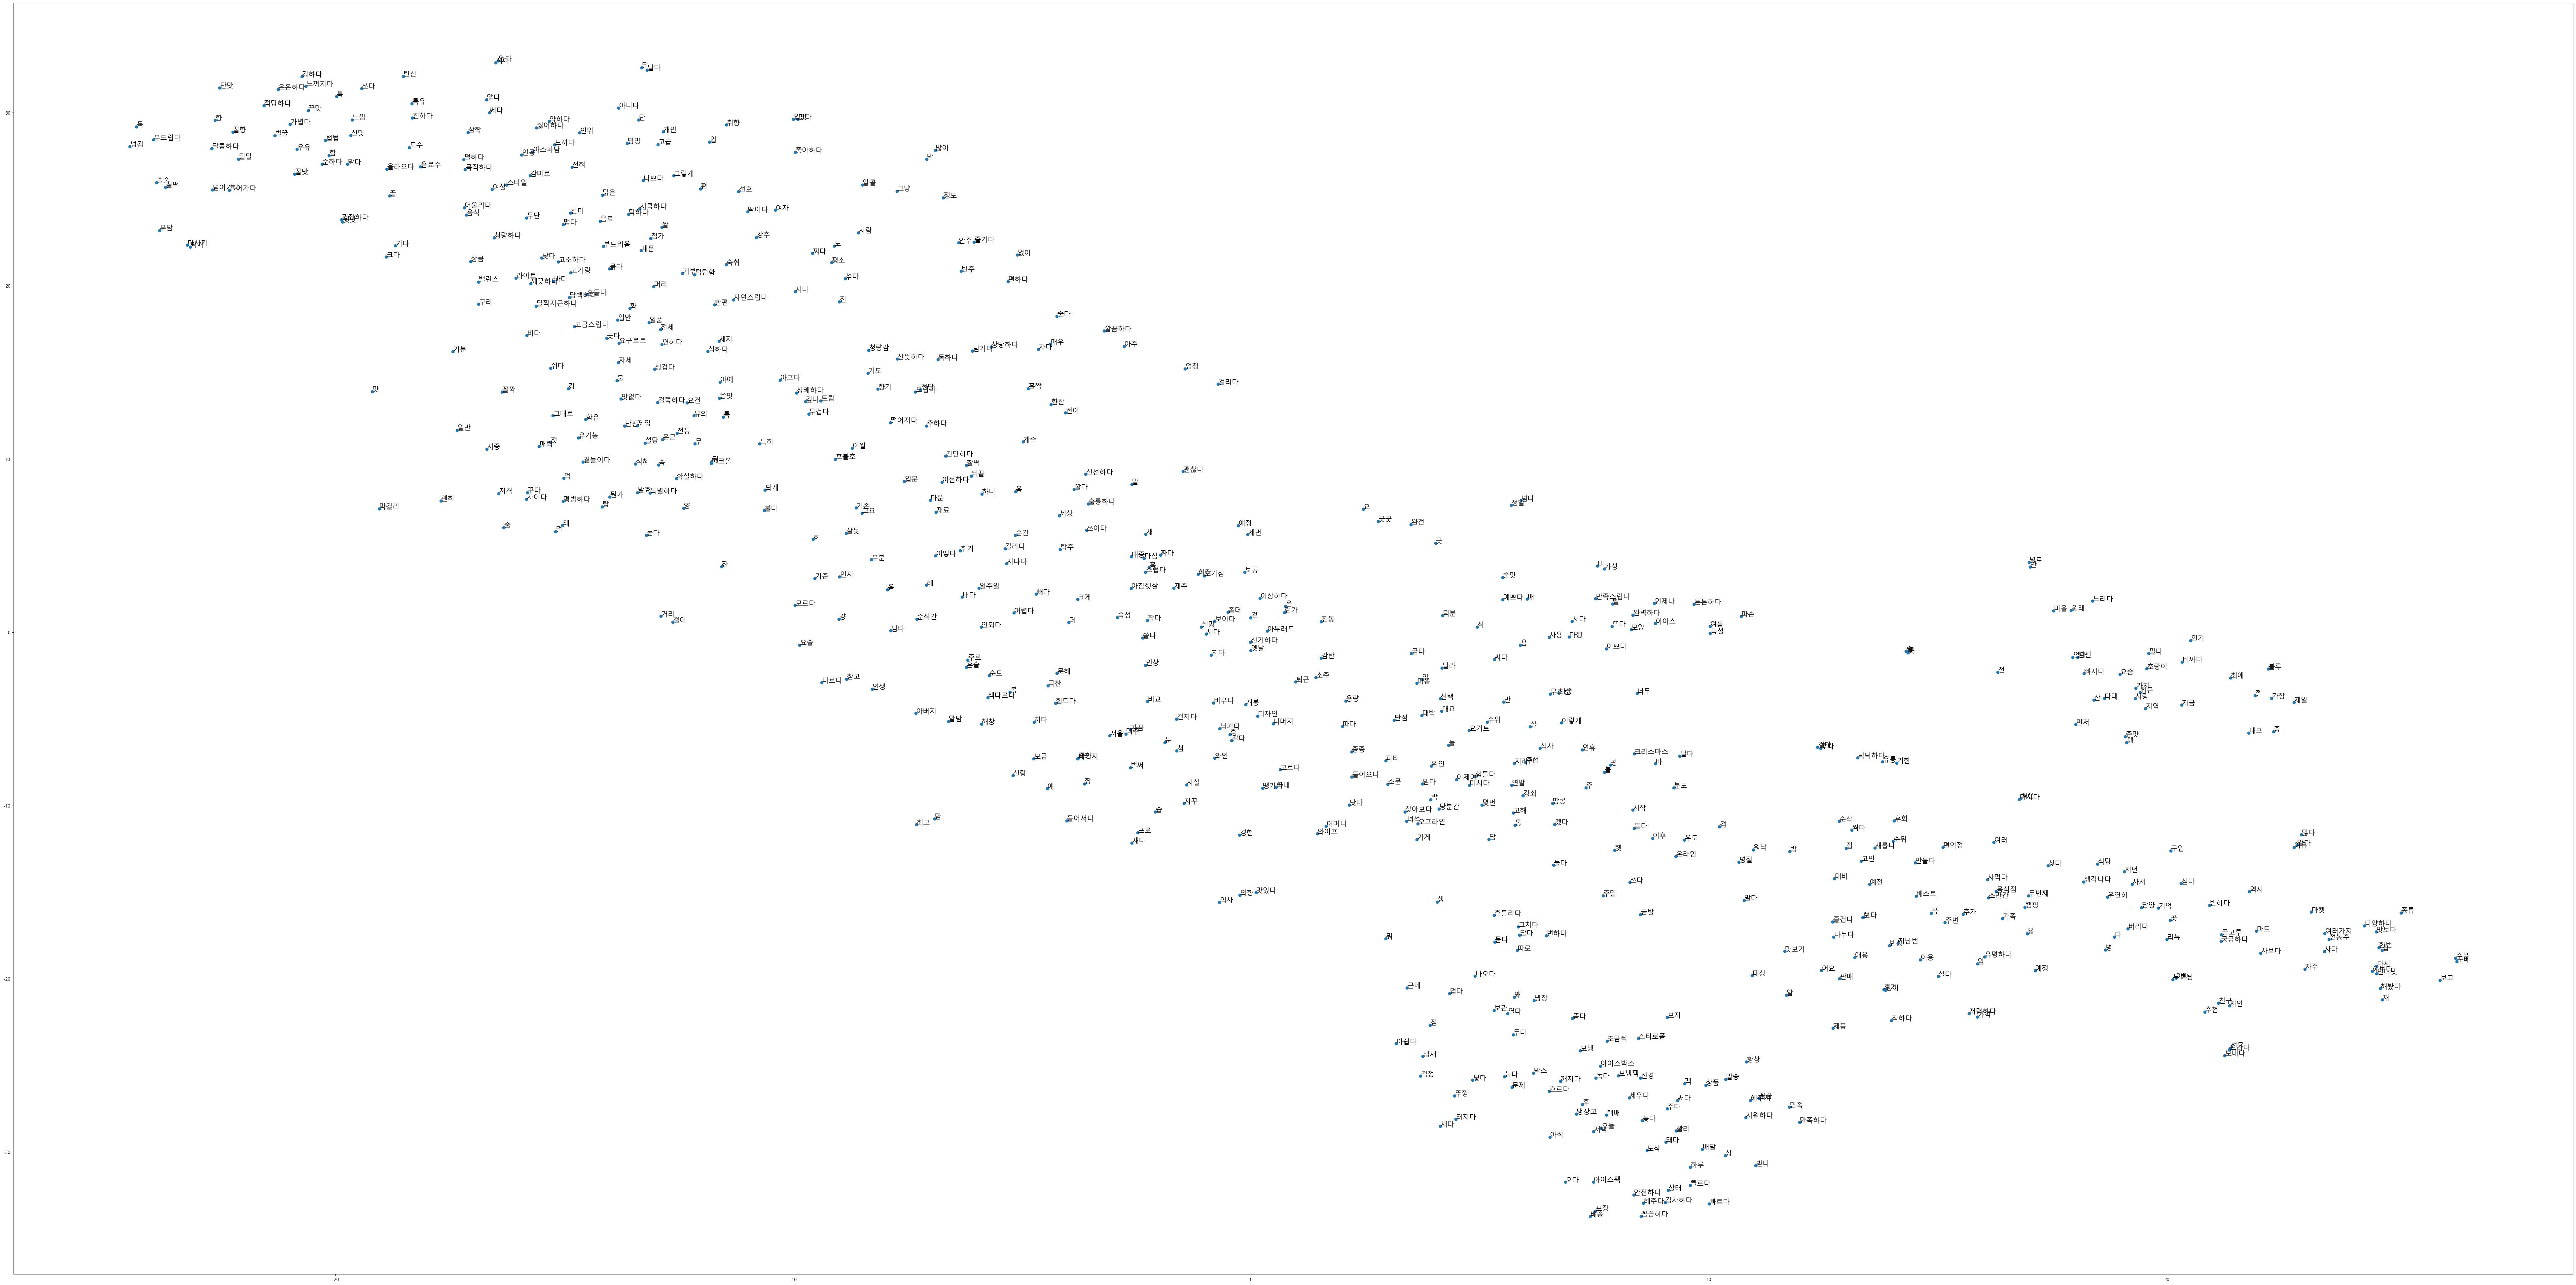

In [40]:
from sklearn.manifold import TSNE
import matplotlib as mpl
import matplotlib.pyplot as plt
import gensim 
import gensim.models as g
from matplotlib import font_manager, rc
from sklearn.cluster import DBSCAN

font_name = font_manager.FontProperties(fname='C:/Windows/Fonts/malgun.ttf').get_name()

rc('font',family=font_name) # 한글 폰트

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False

vocab = list(vocabs)
X = w2v.wv[vocab]

tsne = TSNE(n_components=2, perplexity=30 ,min_grad_norm=1e-4, n_iter=2000)
X_tsne = tsne.fit_transform(X)

df = pd.DataFrame(X_tsne, columns=['x', 'y'])
df.index = vocab
df.shape

fig = plt.figure()
fig.set_size_inches(100, 50)
ax = fig.add_subplot(1, 1, 1)

ax.scatter(df['x'], df['y'])

for word, pos in df.iterrows():
    ax.annotate(word, pos, fontsize=15)
plt.show()